# Poisson equation in 1D with Dirichlet/Periodic boundary conditions

## Problem setup

We will solve a Poisson equation:
$$
-\nabla^2 u = \pi^2 \sin(\pi x), \qquad x \in [-1, 1],
$$
with the Periodic boundary conditions on the right boundary
$$
u(1) = u(-1)
$$

with the Dirichelt boundary conditions on the left boundary
$$
u(-1) = 0, \quad u(1) = 0.
$$

The exact solution is $u(x) = \sin(\pi x)$.

## Implementation

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [ ]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-09 08:52:39.416604: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 08:52:39.416648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 08:52:39.416679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 08:52:39.425081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [ ]:
geom = dde.geometry.Interval(-1, 1)

In [ ]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi**2 * tf.sin(np.pi*x)

In [ ]:
def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], -1)

In [ ]:
def true_solution(x):
    return np.sin(np.pi*x)

In [ ]:
bc_r = dde.icbc.PeriodicBC(geom, 0, boundary_r)
bc_l = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_r, bc_l],
                    num_domain=16,
                    num_boundary=2,
                    solution=true_solution,
                    num_test=100)

In [ ]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.006078 s



Training model...

Cause: could not parse the source code of <function <lambda>>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda>>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric   
0         [4.36e+01, 2.96e-02, 7.40e-03]    [4.93e+01, 2.96e-02, 7.40e-03]    [9.47e-01]    
1000      [4.46e-04, 1.15e-08, 6.13e-08]    [4.50e-04, 1.15e-08, 6.13e-08]    [5.31e-04]    
2000      [3.67e-03, 2.45e-03, 6.31e-04]    [3.17e-03, 2.45e-03, 6.31e-04]    [2.47e-02]    
3000      [5.50e-05, 4.70e-07, 1.75e-

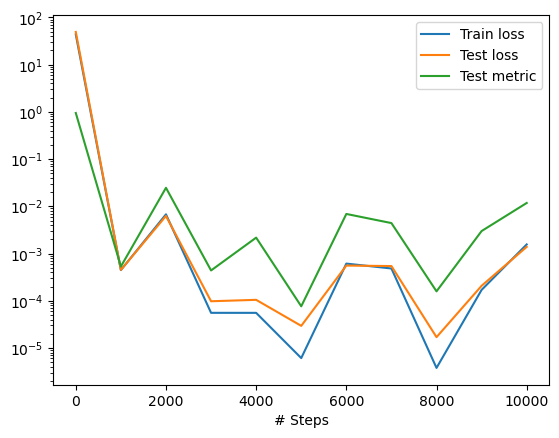

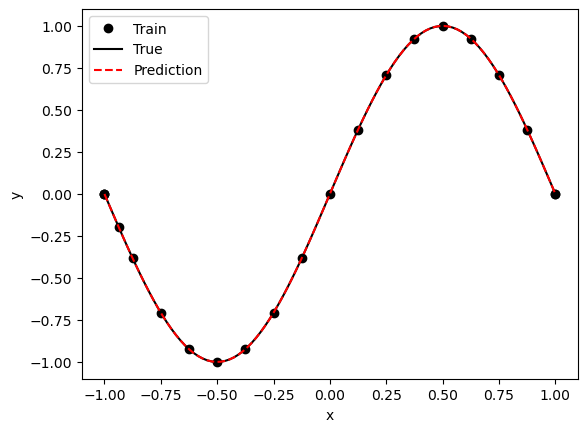

In [ ]:
loss_histroy, train_state = model.train(iterations=int(1e4))
dde.saveplot(loss_histroy, train_state, issave=False, isplot=True)